
# Machine Learning for Genomics - Assignment 2
**Carlos Angel (jcc2340)**

**Username in competition: chrlosangel**

11/03/2023


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load `torch`. Note the version on colab can lag behind the most current release. If you need something new you can install using e.g. !pip3 install torch==1.4.0

In [2]:
import torch
import torch.nn as nn
import torch.utils.data
assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"
print("Torch version:", torch.__version__)

Torch version: 2.1.0+cu118


## Utilities

We'll be using a "one hot" encoding of DNA sequence as the input to our CNN. This can actually be a bottleneck as it runs on the CPU so we use Cython to speed things up.  

In [3]:
%load_ext Cython

In [4]:
%%cython

import numpy as np
np.get_include() # do we need this on colab?
cimport cython
cimport numpy as np

cdef dict bases={ 'A':<int>0, 'C':<int>1, 'G':<int>2, 'T':<int>3 }

@cython.boundscheck(False)
def one_hot( str string ):
    cdef np.ndarray[np.float32_t, ndim=2] res = np.zeros( (4,len(string)), dtype=np.float32 )
    cdef int j
    for j in range(len(string)):
        if string[j] in bases: # bases can be 'N' signifying missing: this corresponds to all 0 in the encoding
            res[ bases[ string[j] ], j ]=float(1.0)
    return(res)


Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_252e1c50adb52c96dd4596fd3f127d904a59396c.c:1215:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

# Pytorch basics

`pytorch` (as opposed to e.g. Theano, Tensorflow 1) uses *eager execution*: this lets you write computations as python code that you can test and debug, and later
1.   Backprop through (i.e. get gradients with respect to inputs)
2.   Run on the GPU for (hopefully!) big speedups.

Here's an example:

In [5]:
x_np = one_hot("CCGCGNGGNGGCAG")
x_tensor = torch.tensor(x_np)
print(x_tensor)
torch.sum(x_tensor, 1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


tensor([1., 4., 7., 0.])

`torch` has equivalents for most `numpy` operations, for example here we got the row sums to check how often each base appeared in our sequence.

As a more exciting example, `torch.nn.functional` has convolutions implemented for us.

In [6]:
import torch.nn.functional as F
help(F.conv1d)

Help on built-in function conv1d in module torch:

conv1d(...)
    conv1d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
    
    Applies a 1D convolution over an input signal composed of several input
    planes.
    
    This operator supports :ref:`TensorFloat32<tf32_on_ampere>`.
    
    See :class:`~torch.nn.Conv1d` for details and output shape.
    
    Note:
        In some circumstances when given tensors on a CUDA device and using CuDNN, this operator may select a nondeterministic algorithm to increase performance. If this is undesirable, you can try to make the operation deterministic (potentially at a performance cost) by setting ``torch.backends.cudnn.deterministic = True``. See :doc:`/notes/randomness` for more information.
    
    Note:
        This operator supports complex data types i.e. ``complex32, complex64, complex128``.
    
    
    Args:
        input: input tensor of shape :math:`(\text{minibatch} , \text{in\_channels} , iW)`
  

Notice `conv1d` expects
1. `input` to have shape batchsize x #input_channels x length (as a warning, `tensorflow` expects batchsize x length x #input_channels!)
2. `weight` (i.e. the filters) to have shape #output_channels x #input_channels x filter_width.

We can make a random tensor for the filters (weights), and then execute the convolution

In [7]:
x_batch = x_tensor[None,:,:] # make a "batch" of size 1
filter_width = 5
my_weights = torch.randn(1, 4, filter_width) # 1 output channels, 4 input channels, filter width = 5
convolution_output = F.conv1d(x_batch, my_weights)
convolution_output

tensor([[[-1.1904, -3.6511, -2.0491, -2.0382, -3.1695, -0.5998, -1.9619,
          -3.7774, -0.2985, -2.0220]]])

Let's check `torch` got the right answer. Here's the calculation for the first position (for data point 0 and output channel 0):

In [8]:
(x_batch[0,:,0:filter_width] * my_weights[0,:,:]).sum()

tensor(-1.1904)

## Task

**Write a for loop to manually calculate the remaining terms in the convolution [1 point]**

In [9]:
my_convolution_output = torch.zeros([1, 1, x_batch.shape[2] - (filter_width-1)])
for i in range(my_convolution_output.shape[2]):
    my_convolution_output[0,0,i] = (x_batch[0,:,i:i+filter_width] * my_weights[0,:,:]).sum()
assert( ((convolution_output - my_convolution_output).abs() < 1e-6).all() )

Note the effect of the (0 padded) convolution on the shape of the output: the sequence length has gone from 14 to 10.

In [10]:
print( x_batch.shape, convolution_output.shape )

torch.Size([1, 4, 14]) torch.Size([1, 1, 10])


Without padding we lose (filter_width-1) positions.

`torch` has nice built in utilities for setting up neural network (NN) layers. For example, we can make a 1D convolutional layer like this:

In [11]:
torch.manual_seed(2) # I played with different initialization here!
my_first_conv_layer = nn.Conv1d(4, 1, 14, padding = 0) # 4 input channels, 1 output channels, filter width 14, no padding
my_first_conv_layer

Conv1d(4, 1, kernel_size=(14,), stride=(1,))

We can use this layer like a function (applied to tensors):

In [12]:
my_first_conv_layer(x_batch)

tensor([[[-0.3852]]], grad_fn=<ConvolutionBackward0>)

But if `my_first_conv_layer` behaves like a function, where are the weights? They're there (along with biases), but they're a little hidden:

In [13]:
list(my_first_conv_layer.parameters())

[Parameter containing:
 tensor([[[ 0.0307, -0.0318,  0.0366, -0.0068,  0.0571,  0.0318, -0.0154,
           -0.1080,  0.0305, -0.1183,  0.0176,  0.0089, -0.0294,  0.1093],
          [ 0.0089,  0.0554,  0.0566, -0.0788, -0.0514,  0.1285, -0.1309,
           -0.0091, -0.0106,  0.0948, -0.0127,  0.0352, -0.0064, -0.0748],
          [-0.0757, -0.0649, -0.1214, -0.0867,  0.0314,  0.0879,  0.0066,
           -0.0613,  0.0587, -0.0513, -0.0296, -0.0733, -0.0420, -0.1238],
          [ 0.0570,  0.0520,  0.0265,  0.0656,  0.0566,  0.0059,  0.0142,
            0.0102,  0.0713,  0.0898,  0.0960,  0.0775, -0.0326, -0.0059]]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0272], requires_grad=True)]

But where did these numbers come from? `torch` by default initializes using the very reasonable [Kaiming/He initalization](https://arxiv.org/abs/1502.01852) which aims to keep the variance of the hidden layer activations reasonably stable (constant in expectation) through the network.

# My First Convolutional Neural Network

We're ready to make the simplest CNN possible where we just take the max over all the convolution outputs:

In [14]:
def my_simplest_CNN(x):
    net = my_first_conv_layer(x)
    net = net[:,0,:] # only one output channel!
    # take maximum over channel ("global max pooling")
    net = torch.max(net, dim=1).values # max returns namedtuple (values, indices)
    net = torch.sigmoid(net) # aka logistic to get output in [0,1]
    return(net)

my_simplest_CNN(x_batch)

tensor([0.4049], grad_fn=<SigmoidBackward0>)

## Loading data

To test this out we need some data! Our first task will be predict binding of the important transcriptional repressor CTCF in a human lung cancer cell line called A549. The data is available from ENCODE including merging replicate experiments using the "irreproducible discovery rate" (IDR) [paper](https://arxiv.org/abs/1110.4705) [code](https://github.com/spundhir/idr). Genomics data representing discrete binding events is typically stored in the  `bed` format, which is described on the UCSC Genome Browser [website](https://genome.ucsc.edu/FAQ/FAQformat.html#format1). This bed file has some additional columns we will ignore.

In [15]:
import os
os.getcwd()

'/content'

In [16]:
import pandas as pd
DATADIR = "/content/drive/MyDrive/Assignment 2/" # might need to change this
binding_data = pd.read_csv(DATADIR + "ENCFF300IYQ.bed.gz", sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data[:10]

,chrom,start,end,name,score,strand
3417,chr1,714156,714372,.,1000,.
28093,chr1,805243,805372,.,1000,.
32029,chr1,840059,840248,.,1000,.
17195,chr1,848298,848514,.,1000,.
6610,chr1,855056,855272,.,1000,.
10598,chr1,856479,856695,.,1000,.
15904,chr1,858493,858709,.,1000,.
16616,chr1,860345,860561,.,1000,.
10818,chr1,860967,861183,.,1000,.
31703,chr1,873565,873753,.,1000,.


`chrom` is the chromosome (we filter out the sex chromosomes X and Y to avoid bias from these being haploid, you could try keeping them though). `start` and `end` are positions in the genome. `name` and `strand` aren't used here. Some genomics assays (e.g. RNA-seq) correspond to one strand of the DNA or the other. However, for our purposes at least we can consider ChIP-seq and ATAC-seq as "unstranded", which is why that column is all "." rather than + or -.  `score` is a quantitative measure of binding. We'll ignore this for now (since all these peaks are statistically significant), but you could try to incorporate it in your model training if you want (e.g. multitask for binary binding plus predicting `score`).

We'll split the binding data into training, validation (chroms 2 and 3, ~) and test (chrom 1), which represents about 14% of the training data we have:

In [17]:
test_chromosomes = ["chr1"]
test_data = binding_data[ binding_data['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = binding_data[ binding_data['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = binding_data[ binding_data['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / binding_data.shape[0], validation_data.shape[0] / binding_data.shape[0]

(0.0924340093163318, 0.1410859643344469)

We'll also need the human genome, which we provide here as a pickle since it's faster to load compared to reading in a text file.

It's worth knowing that the human genome has different *versions* that are released as more missing parts are resolved by continued sequencing and assembly efforts. Version `GRCh37` (also called `hg19`) was released in 2009, and `GRCh38` (`hg38`) was released in 2013. We'll be using `hg19` here but `GRCh38` is finally becoming more standard so always check your data is what you think it is.

This will take a minute or two.

In [18]:
import pickle
#genome = pickle.load(open(DATADIR+"hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse
genome = pickle.load(open(DATADIR+"hg19.pickle","rb"))

`genome` is just a dictionary where the keys are the chromosome names and the values are strings representing the actual DNA:

In [19]:
genome["chr13"][100000000:100000010]

'GTGATAACGT'

You'll find a substantial proportion of each chromosome is "N"s:

In [20]:
genome["chr13"].count("N") / len(genome["chr13"])

0.17000973119030308

Ns represents "missing" regions, typically because the region has too many repetitive sequences making mapping impossible, which is especially the case in [centrosomes](https://en.wikipedia.org/wiki/Centrosome) and [telomeres](https://en.wikipedia.org/wiki/Telomere). Resolving these difficult to map regions is an ongoing effort.

We'll use the `torch` data loading utilities (nicely documented [here](https://pytorch.org/docs/stable/data.html)) to handle
1. Grouping individual (x,y) pairs into minibatches.
2. Converting `numpy` arrays into `torch` tensors.

We could also use `num_workers>0` to have a background process generating the next batch using the CPU while the GPU is working, but in my experience this actually slows things down. If you were in a computer vision setting where you wanted to do intensive [data augmentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) it might make a difference.

In [21]:
# positive example: binding of protein onto sequence (ChIP-seq (TF ChIP-seq))
# negative example: the ones that do not overlap with the positive examples
# for chip-seq data: also shuffling nucleotides can be done to keep the GC content the same as positive example
# because sequencing has biases with GC content and this would be a way to "fix it"
class BedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, atac_data, genome, context_length):
        super(BedPeaksDataset, self).__init__()
        self.context_length = context_length
        self.atac_data = atac_data
        self.genome = genome

    def __iter__(self):
        prev_end = 0
        prev_chrom = ""
        for i,row in enumerate(self.atac_data.itertuples()):
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chrom][ midpoint - self.context_length//2:midpoint + self.context_length//2]
            yield(one_hot(seq), np.float32(1)) # positive example

            if prev_chrom == row.chrom and prev_end < row.start:
                midpoint = int(.5 * (prev_end + row.start))
                seq = self.genome[row.chrom][ midpoint - self.context_length//2:midpoint + self.context_length//2]
                yield(one_hot(seq), np.float32(0)) # negative example midway inbetween peaks, could randomize

            prev_chrom = row.chrom
            prev_end = row.end

train_dataset = BedPeaksDataset(train_data, genome, 100)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)

train_data

,chrom,start,end,name,score,strand
6094,chr10,119905,120121,.,977,.
18051,chr10,122432,122648,.,1000,.
14300,chr10,183139,183355,.,1000,.
19341,chr10,276844,276914,.,1000,.
17727,chr10,325694,325910,.,1000,.
...,...,...,...,...,...,...
8866,chr9,140862899,140863115,.,998,.
31972,chr9,140916866,140917028,.,1000,.
22970,chr9,140948983,140949199,.,1000,.
4812,chr9,140960493,140960709,.,1000,.


## Training

Let's train our super simple CNN using stochastic gradient descent:

In [22]:
import timeit
start_time = timeit.default_timer()

torch.set_grad_enabled(True) # we'll need gradients

for epoch in range(10): # run for this many epochs
    losses = []
    accuracies = []
    for (x,y) in train_dataloader: # iterate over minibatches

        output = my_simplest_CNN(x) # forward pass
        # in practice (and below) we'll use more numerically stable built-in
        # functions for the loss
        loss = - torch.mean( y * torch.log(output) + (1.-y) * torch.log(1.-output) )
        loss.backward() # back propagation

        # iterate over parameter tensors: just the layer1 weights and bias here
        for parameters in my_first_conv_layer.parameters():
            parameters.data -= 1.0 * parameters.grad # in practive reduce or adapt learning rate
            parameters.grad.data.zero_() # torch accumulates gradients so need to reset

        losses.append(loss.detach().numpy()) # convert back to numpy
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().numpy())

    elapsed = float(timeit.default_timer() - start_time)
    print("Epoch %i %.2fs/epoch Loss: %.4f Acc: %.4f" % (epoch+1, elapsed/(epoch+1), np.mean(losses), np.mean(accuracies)))


Epoch 1 2.71s/epoch Loss: 0.5535 Acc: 0.7388
Epoch 2 3.37s/epoch Loss: 0.4895 Acc: 0.7632
Epoch 3 3.54s/epoch Loss: 0.4492 Acc: 0.7939
Epoch 4 3.30s/epoch Loss: 0.3835 Acc: 0.8322
Epoch 5 3.11s/epoch Loss: 0.3422 Acc: 0.8540
Epoch 6 2.98s/epoch Loss: 0.3321 Acc: 0.8574
Epoch 7 2.92s/epoch Loss: 0.3286 Acc: 0.8587
Epoch 8 3.08s/epoch Loss: 0.3269 Acc: 0.8589
Epoch 9 3.11s/epoch Loss: 0.3260 Acc: 0.8591
Epoch 10 3.05s/epoch Loss: 0.3255 Acc: 0.8592


So we can get pretty decent accuracy even with this very simple CNN (although I cheated a bit by trying a few random seeds and knowing that the CTCF consensus motif is 14nt long so would require a width 14 filter).

In [23]:
validation_dataset = BedPeaksDataset(validation_data, genome, 100)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)
accuracies = [ torch.mean( ( (my_simplest_CNN(x)  > .5) == (y > .5) ).float() ).detach().cpu().numpy() for (x,y) in validation_dataloader ]
np.mean(accuracies)

0.83062035

The validation accuracy is very similiar to the train accuracy, suggesting we're not overfitting (as we would expect with such a simple model).

## Model interpretation

Since this model used only a single convolutional filter it's very easy to interpret how it's making predictions. In genetics it's common to plot position weight matrices as "sequence logos":

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 50.2 MB/s eta 0:00:00


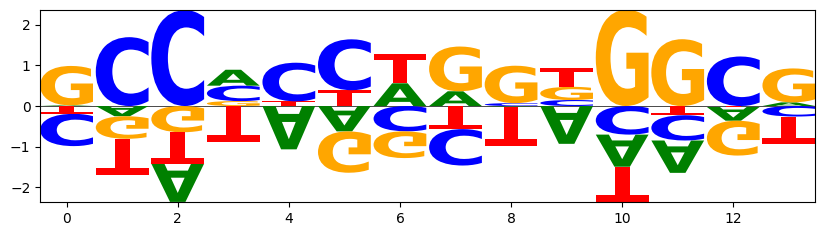

In [24]:
!pip install logomaker
import logomaker
pwm = my_first_conv_layer.weight.detach().cpu().numpy().squeeze()
pwm -= pwm.mean(0, keepdims=True) # remove spurious degrees of freedom
pwm_df = pd.DataFrame(data = pwm.transpose(), columns=("A","C","G","T"))
crp_logo = logomaker.Logo(pwm_df) # CCACCAGG(G/T)GGCG

Characters above (below) the x-axis correspond to positive (negative) values. Our model has some additional degrees of freedom (we could add a constant k to each column of the filter and substract k from the bias without changing the prediction) which we remove. Compare this to the "known" sequence motif: [JASPAR CTCF](http://jaspar.genereg.net/matrix/MA0139.1/) to see it's a pretty good match.

# A full LeNet-type CNN

Let's see if we can do better with a full CNN. While it's not strictly necessary it's convenient to encapsulate the model as a class inheriting from `nn.Module`. This allows automatic handling of things like:
1. Extracting all model parameters.
2. Setting all layers to train or eval mode (for layers like dropout that behave differently in the two settings).
Note that here we used the model architecture to specify the length of sequence (the "sequence context") that is considered (stored as cnn_1d.seq_len). "num_chunks" here corresponds to the sequence length of the hidden layer after the last convolutional layer. The other common approach is to instead specify the sequence context and use the formula we covered in class to calculate the sequence length L for each each hidden layer (you're welcome to try implementing that approach!)

In [25]:
class CNN_1d(nn.Module):

    def __init__(self,
                 n_output_channels = 1,
                 filter_widths = [15, 5],
                 num_chunks = 5,
                 max_pool_factor = 4,
                 nchannels = [4, 32, 32],
                 n_hidden = 32,
                 dropout = 0.2):

        super(CNN_1d, self).__init__()
        self.rf = 0 # running estimate of the receptive field
        self.chunk_size = 1 # running estimate of num basepairs corresponding to one position after convolutions

        conv_layers = []
        for i in range(len(nchannels)-1):
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding = 0),
                        nn.BatchNorm1d(nchannels[i+1]), # tends to help give faster convergence: https://arxiv.org/abs/1502.03167
                        nn.Dropout2d(dropout), # popular form of regularization: https://jmlr.org/papers/v15/srivastava14a.html
                        nn.MaxPool1d(max_pool_factor),
                        nn.ELU(inplace=True)  ] # popular alternative to ReLU: https://arxiv.org/abs/1511.07289
            assert(filter_widths[i] % 2 == 1) # assume this
            self.rf += (filter_widths[i] - 1) * self.chunk_size
            self.chunk_size *= max_pool_factor

        # If you have a model with lots of layers, you can create a list first and
        # then use the * operator to expand the list into positional arguments, like this:
        self.conv_net = nn.Sequential(*conv_layers)

        self.seq_len = num_chunks * self.chunk_size + self.rf # amount of sequence context required

        print("Receptive field:", self.rf, "Chunk size:", self.chunk_size, "Number chunks:", num_chunks)

        self.dense_net = nn.Sequential( nn.Linear(nchannels[-1] * num_chunks, n_hidden),
                                        nn.Dropout(dropout),
                                        nn.ELU(inplace=True),
                                        nn.Linear(n_hidden, n_output_channels) )

    def forward(self, x):
        net = self.conv_net(x)
        net = net.view(net.size(0), -1)
        net = self.dense_net(net)
        return(net)

cnn_1d = CNN_1d()

print("Input length:", cnn_1d.seq_len)

cnn_1d

Receptive field: 30 Chunk size: 16 Number chunks: 5
Input length: 110


CNN_1d(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): ELU(alpha=1.0, inplace=True)
  )
  (dense_net): Sequential(
    (0): Linear(in_features=160, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

The `torch` output nicely illustrates the various layers in our network. We have two convolutional units each doing conv -> batchnorm -> dropout -> maxpooling -> activation, followed by two layers of dense network, including a dropout layer.

We'll recreate the dataloaders to satisfy the input sequence length requirement of the new model.


In [26]:
train_dataset = BedPeaksDataset(train_data, genome, cnn_1d.seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)
validation_dataset = BedPeaksDataset(validation_data, genome, cnn_1d.seq_len)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)


## Transfering to the GPU
The previous example actually ran on the CPU. Now we're using a more complex model it'll be worth running on the GPU. To do that we need to transfer both model and data. Transfering the model:

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_1d.to(device)
print(device)

cuda


Check that this says `cuda` not `cpu`! You need to go to Runtime -> Change runtime type -> Set "Hardware Accelerator" -> GPU (or TPU) if not.

Next we'll set up the optimizer. `torch` has a number of [optimizers](https://pytorch.org/docs/stable/optim.html), most of which are variants of SGD. [Adam](https://arxiv.org/abs/1412.6980) with the [AMSgrad convergence fix](https://openreview.net/forum?id=ryQu7f-RZ) is a good default in my experience.

In [28]:
optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True)

We define a training loop which can be used for both training and validation loops by setting the `train_flag`.

In [29]:
def run_one_epoch(train_flag, dataloader, cnn_1d, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval()

    losses = []
    accuracies = []

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = cnn_1d(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable

        if train_flag:
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > 0.0) == (y > 0.5) ).float() ) # output is in logit space so threshold is 0.
        accuracies.append(accuracy.detach().cpu().numpy())

    return( np.mean(losses), np.mean(accuracies) )

## Training
Ok let's train! We'll keep track of validation loss to do [early stopping](https://en.wikipedia.org/wiki/Early_stopping): if we don't see any improvement in the validation validation loss for 10 consecutive epochs then we stop training. This will take a few minutes.

In [30]:
train_accs = []
val_accs = []
patience = 10 # for early stopping
patience_counter = patience
best_val_loss = np.inf
check_point_filename = 'cnn_1d_checkpoint.pt' # to save the best model fit to date
for epoch in range(100):
    start_time = timeit.default_timer()
    train_loss, train_acc = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device)
    val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    if val_loss < best_val_loss:
        torch.save(cnn_1d.state_dict(), check_point_filename)
        best_val_loss = val_loss
        patience_counter = patience
    else:
        patience_counter -= 1
        if patience_counter <= 0:
            cnn_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
            break
    elapsed = float(timeit.default_timer() - start_time)
    print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" %
          (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Epoch 1 took 18.72s. Train loss: 0.5369 acc: 0.7186. Val loss: 0.4287 acc: 0.7912. Patience left: 10
Epoch 2 took 3.97s. Train loss: 0.4474 acc: 0.7776. Val loss: 0.3631 acc: 0.8274. Patience left: 10
Epoch 3 took 3.39s. Train loss: 0.3948 acc: 0.8096. Val loss: 0.3099 acc: 0.8634. Patience left: 10
Epoch 4 took 4.43s. Train loss: 0.3443 acc: 0.8411. Val loss: 0.2618 acc: 0.8897. Patience left: 10
Epoch 5 took 3.13s. Train loss: 0.3057 acc: 0.8629. Val loss: 0.2469 acc: 0.8972. Patience left: 10
Epoch 6 took 2.70s. Train loss: 0.2834 acc: 0.8757. Val loss: 0.2300 acc: 0.9063. Patience left: 10
Epoch 7 took 2.87s. Train loss: 0.2679 acc: 0.8851. Val loss: 0.2241 acc: 0.9090. Patience left: 10
Epoch 8 took 3.21s. Train loss: 0.2572 acc: 0.8915. Val loss: 0.2038 acc: 0.9151. Patience left: 10
Epoch 9 took 4.66s. Train loss: 0.2475 acc: 0.8952. Val loss: 0.2018 acc: 0.9180. Patience left: 10
Epoch 10 took 3.10s. Train loss: 0.2405 acc: 0.8993. Val loss: 0.1950 acc: 0.9211. Patience left: 1

Rather than trying to stare at those numbers let's plot training and validation accuracy:

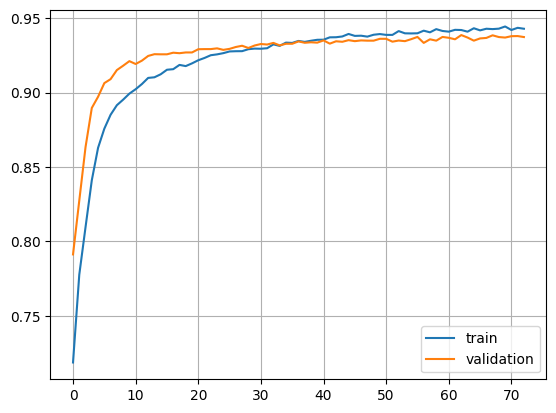

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="validation")
plt.legend()
plt.grid(which="both")

Unusually the validation accuracy is higher than the train accuracy in some places! This could be due to (at least) two factors:
1. Relatively small validation set so the estimate is noisy.
2. Dropout introduces noise into the predictions during training but not validation (as it should).
We could actually test this by evaluating on the training data without dropout:

In [32]:
train_loss, train_acc = run_one_epoch(False, train_dataloader, cnn_1d, optimizer, device)
val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)
print(train_acc, val_acc)

0.9556359 0.9386197


As expected, the validation accuracy is a little lower. Strictly speaking we should also check performance on the test set since we used the validation set to do early stopping.

In [33]:
test_dataset = BedPeaksDataset(test_data, genome, cnn_1d.seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_loss, test_acc = run_one_epoch(False, test_dataloader, cnn_1d, optimizer, device)
test_acc

0.9421813

In [34]:
cnn_1d.seq_len

110

Nice, the test set accuracy is high too.

## Model interpretation

Model interpretation is an active area of research for CNNs. Two baseline approaches in genomics are *in silico* mutagenesis and saliency maps. Good approaches exist for explaining the prediction for a single instance: explaining how the model works globally is still a challenge in general.

### in silico mutatgenesis

This approach is specific to genomics where we can imagine making individual "point" mutations (changing just one base) and seeing what effect that has on the model's prediction. In computer vision there isn't a direct analogy: deleting or changing a single pixel would rarely (if ever) change the prediction we would expect (although CNNs are not necessarily robust to such changes - adversarial training attempts to make them so).  

*in silico* mutagenesis can be used both for model interpretation (as we do here) and predicting the effects of real mutations/genetic differences between individuals.

We'll just run mutagenesis for the first batch of the validation data:

In [35]:
torch.set_grad_enabled(False)
for (x_cpu,y_cpu) in validation_dataloader:
    x = x_cpu.to(device)
    y = y_cpu.to(device)
    output = cnn_1d(x).squeeze()
    output = torch.sigmoid(output)
    delta_output = torch.zeros_like(x, device=device)
    # loop over all positions changing to each position nucleotide
    # note everything is implicitly parallelized over the batch here
    for seq_idx in range(cnn_1d.seq_len): # iterate over sequence
        for nt_idx in range(4): # iterate over nucleotides
            x_prime = x.clone() # make a copy of x
            x_prime[:,:,seq_idx] = 0. # change the nucleotide to nt_idx
            x_prime[:,nt_idx,seq_idx] = 1.
            output_prime = cnn_1d(x_prime).squeeze()
            output_prime = torch.sigmoid(output_prime)
            delta_output[:,nt_idx,seq_idx] = output_prime - output
    break # just do this for first batch

Note how computationally expensive this is: for every instance we do inference $4 \times L$ times (we could make this $3 \times L$ easily enough).

We'll visualize just four (2 positive 2 negative) examples:

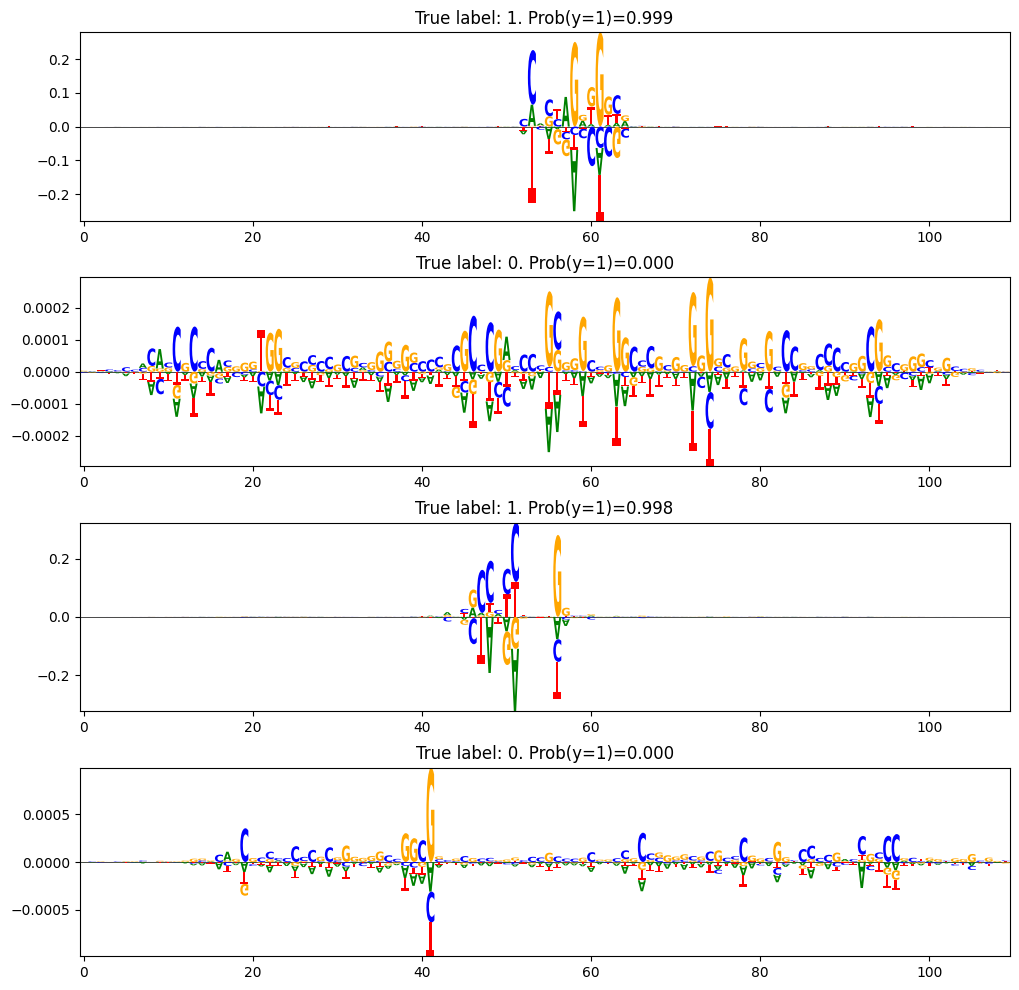

In [36]:
delta_output_np = delta_output.detach().cpu().numpy()
delta_output_np -= delta_output_np.mean(1, keepdims=True)
output_np = output.detach().cpu().numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i)
    pwm_df = pd.DataFrame(data = delta_output_np[i,:,:].transpose(), columns=("A","C","G","T"))
    crp_logo = logomaker.Logo(pwm_df, ax = ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

Note the difference in the y-axis scales! For the two positive examples there are clear regions in the sequence that if disrupted significantly impact the prediction. For the negative examples there is a scattering of "mutations" that would effect the prediction, presumably by randomly introducing a sequence that looks a little like the CTCF motif (we don't expect any specific features in these negative sequences).

### Saliency maps

This is the simplest approach to leverage the same backprop machinery that we use during training. The trick is that instead of taking the gradient w.r.t. parameters we'll now take the gradient w.r.t. inputs `x`. Specifically here we'll get the gradient of $P(y=1|x)$ w.r.t x. The `saliency` itself is defined as that gradient elementwise multiplied with `x` itself.

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


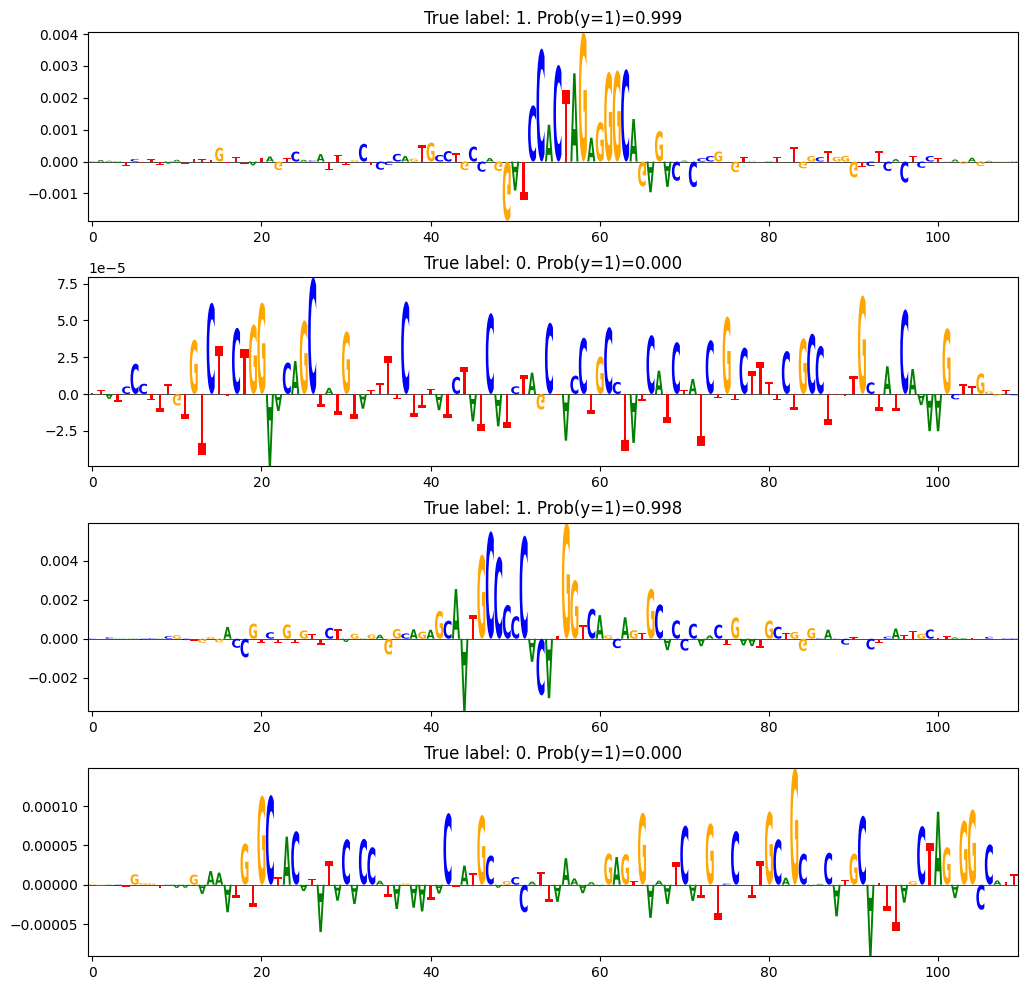

In [37]:
torch.set_grad_enabled(True)
x.requires_grad_() # tell torch we will want gradients wrt x (which we don't normally need)
output = cnn_1d(x).squeeze()
output = torch.sigmoid(output)
dummy = torch.ones_like(output) # in a multiclass model this would be a one-hot encoding of y
output.backward(dummy) # to get derivative wrt to x
gradient_np = x.grad.detach().cpu().numpy()
output_np = output.detach().cpu().numpy()
saliency = gradient_np * x_cpu.numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i) #,sharey=ax)
    pwm_df = pd.DataFrame(data = saliency[i,:,:].transpose(), columns=("A","C","G","T"))
    logomaker.Logo(pwm_df, ax=ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

This is much more computationally efficient than in silico mutagenesis, requiring only ONE forward and backward pass. Compare the two interpretation methods: for the positive examples the same sequence regions are highlighted (although the saliency map is noisier outside that region).

### Other interpretation approaches

There's a nice compedium and associated `torch` code for a number methods [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations). Some that I would add:
1. DeepLIFT  [paper](https://arxiv.org/abs/1704.02685) [code](https://github.com/kundajelab/deeplift) - no `pytorch` support sadly.
2. DeepSHAP [paper](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) [code](https://github.com/slundberg/shap)
3. Influence functions. [paper](https://arxiv.org/abs/1703.04730) [code](https://github.com/kohpangwei/influence-release). A little different: finds which training points most strongly influence the current prediction.

## A more challenging task

CTCF binding is relatively easy to predict, mostly depending on homotypic binding with a strong motif. Here you'll attempt a more difficult task: predicting chromatin accessibility (as measured by ATAC-seq) for a mystery cell type (mysterious so you can fairly compete in the competition below!) Let's load data and split into training and validation - I've already removed chromosome 1 and 2 data as test set to be used in the competition at the end.

In [65]:
atac_data = pd.read_csv(DATADIR + "ATAC_data.bed.gz", sep='\t', names=("chrom","start","end"))
atac_data = atac_data.sort_values(['chrom', 'start']) # actually already sorted but why not

validation_chromosomes = ["chr3","chr4"]
validation_data = atac_data[ atac_data['chrom'].isin(validation_chromosomes) ]

train_data = atac_data[ ~atac_data['chrom'].isin( validation_chromosomes ) ]

train_data.shape[0] / atac_data.shape[0], validation_data.shape[0] / atac_data.shape[0]

(0.812797461660497, 0.1872025383395029)

# Tasks

Make your own copy of this notebook complete the following questions by filling in the code and write-up sections. Feel free to add cells as needed.

## Wrapper function [2 points]

It will be helpful to make a wrapper function that does the following:
1. Make new `BedPeakDataset` and `DataLoader` objects for both training and validation data.
2. Instantiates an optimizer for the model.
3. Runs the training loop with early stopping.
4. Returns the fitted model, train and validation accuracies.

We've given a suggested signature for the wrapper function. You'll find the code snippets you need above although you will need to do some minor editing if you want the optional arguments to have the correct effects.

In [39]:
def train_model(cnn_1d, train_data, validation_data,lr, epochs=100, patience=10, verbose = True,model_name="cnn_1d_checkpoint_new.pt"):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d.to(device)
    if verbose:
        print(device)

    # 1. Make new BedPeakDataset and DataLoader objects for both training and validation data.
    train_dataset = BedPeaksDataset(train_data, genome, cnn_1d.seq_len) #should we use the same context length as before?
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)
    validation_dataset = BedPeaksDataset(validation_data, genome, cnn_1d.seq_len)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)


    # 2. Instantiates an optimizer for the model.
    #default lr=0.001
    optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True, lr=lr)

    # 3. Run the training loop with early stopping.
    train_accs = []
    val_accs = []
    patience = patience
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = model_name # to save the best model fit to date
    #100 epochs
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        # Run one training epoch
        train_loss, train_acc = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device)
        # Run the model for one epoch on validation data (without backpropagation)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # If validation loss is lower than the best seen so far, save the model parameters
        if val_loss < best_val_loss:
            torch.save(cnn_1d.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            # Decrease the patience counter if there was no improvement in validation loss
            patience_counter -= 1
            # If patience has run out, load the best model and break out of the loop
            if patience_counter <= 0:
                cnn_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break #early stopping
            # Calculate the elapsed time for the current epoch
        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" %
              (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    return cnn_1d, train_accs, val_accs

In [85]:
from torch.optim.lr_scheduler import StepLR

def train_model(cnn_1d, train_data, validation_data, lr, epochs=100, patience=10, verbose=True, model_name="cnn_1d_checkpoint_new.pt", scheduler=None):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d.to(device)
    if verbose:
        print("Training on device:", device)

    # Initialize the datasets and dataloaders
    train_dataset = BedPeaksDataset(train_data, genome, cnn_1d.seq_len)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers=0)
    validation_dataset = BedPeaksDataset(validation_data, genome, cnn_1d.seq_len)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)

    # Initialize the optimizer
    optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True, lr=lr)

    # Training loop with early stopping
    train_accs, val_accs = [], []
    best_val_loss = np.inf
    patience_counter = patience

    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            torch.save(cnn_1d.state_dict(), model_name)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            patience_counter -= 1
            if patience_counter <= 0:
                cnn_1d.load_state_dict(torch.load(model_name))
                break

        if scheduler:
            scheduler.step()

        elapsed = timeit.default_timer() - start_time
        if verbose:
            print(f"Epoch {epoch+1} took {elapsed:.2f}s. Train loss: {train_loss:.4f} acc: {train_acc:.4f}. Val loss: {val_loss:.4f} acc: {val_acc:.4f}. Patience left: {patience_counter}")

    return cnn_1d, train_accs, val_accs


You should now be able to train a basic CNN with the same architechure as we used above for CTCF binding prediction.

In [40]:
import timeit
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d, train_accs, val_accs = train_model(my_cnn1d, train_data, validation_data,lr=0.001)

Receptive field: 30 Chunk size: 16 Number chunks: 5
110
cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Epoch 1 took 4.03s. Train loss: 0.6696 acc: 0.5854. Val loss: 0.6479 acc: 0.6161. Patience left: 10
Epoch 2 took 2.14s. Train loss: 0.6511 acc: 0.6120. Val loss: 0.6384 acc: 0.6245. Patience left: 10
Epoch 3 took 3.27s. Train loss: 0.6437 acc: 0.6218. Val loss: 0.6295 acc: 0.6378. Patience left: 10
Epoch 4 took 3.48s. Train loss: 0.6355 acc: 0.6303. Val loss: 0.6186 acc: 0.6499. Patience left: 10
Epoch 5 took 2.45s. Train loss: 0.6310 acc: 0.6382. Val loss: 0.6113 acc: 0.6581. Patience left: 10
Epoch 6 took 2.27s. Train loss: 0.6243 acc: 0.6439. Val loss: 0.6045 acc: 0.6663. Patience left: 10
Epoch 7 took 2.15s. Train loss: 0.6182 acc: 0.6512. Val loss: 0.5944 acc: 0.6795. Patience left: 10
Epoch 8 took 2.12s. Train loss: 0.6086 acc: 0.6639. Val loss: 0.5870 acc: 0.6847. Patience left: 10
Epoch 9 took 2.64s. Train loss: 0.6005 acc: 0.6703. Val loss: 0.5867 acc: 0.6917. Patience left: 10
Epoch 10 took 3.50s. Train loss: 0.5914 acc: 0.6801. Val loss: 0.5681 acc: 0.7075. Patience left: 10

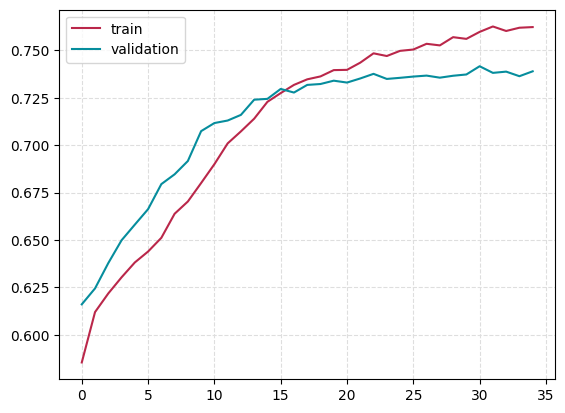

In [41]:
import matplotlib.pyplot as plt
plt.plot(train_accs, label="train",color='#BA274A')
plt.plot(val_accs, label="validation",color='#068D9D')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.87')

## Question 1 [4 points]

a. Find settings of `CNN_1d` that underfit (low train and validation accuracy) and plot the train and validation accuracy. [3 points]

In [ ]:
#n_output_channels = 1,
#filter_widths = [15, 5],
#num_chunks = 5, #split the sequence into chunks
#max_pool_factor = 4,
#nchannels = [4, 32, 32], #for each convolutional layer.
#n_hidden = 32, #number of hidden units in the fully connected layer
#dropout = 0.2
#It works by randomly setting a fraction of the input units to 0 at each update during the training phase, which helps to prevent complex co-adaptations on training data. It's like each iteration trains a different model with a slightly different architecture, but all these models share weights. This encourages the network to develop a more robust set of features that are useful in more varied contexts, rather than relying on any small set of neurons.

cnn_1d_underfit = CNN_1d(n_output_channels=1,
                          filter_widths=[25], # fewer filters (wider receptive field)
                          num_chunks=5,
                          max_pool_factor=4,
                          nchannels=[4, 8], # fewer channels
                          n_hidden=12, # fewer hidden units
                          dropout=0.9) # more dropout
my_cnn1d_underfit, train_accs_u, val_accs_u = train_model(cnn_1d_underfit, train_data, validation_data,lr=0.1)


Receptive field: 24 Chunk size: 4 Number chunks: 3
cuda
Epoch 1 took 0.96s. Train loss: 0.7038 acc: 0.5004. Val loss: 0.6942 acc: 0.5001. Patience left: 10
Epoch 2 took 0.95s. Train loss: 0.6940 acc: 0.5004. Val loss: 0.6933 acc: 0.5001. Patience left: 10
Epoch 3 took 0.94s. Train loss: 0.6932 acc: 0.5039. Val loss: 0.6936 acc: 0.5001. Patience left: 9
Epoch 4 took 0.96s. Train loss: 0.6938 acc: 0.5004. Val loss: 0.6959 acc: 0.5001. Patience left: 8
Epoch 5 took 0.94s. Train loss: 0.6936 acc: 0.5032. Val loss: 0.6933 acc: 0.4999. Patience left: 7
Epoch 6 took 0.98s. Train loss: 0.6935 acc: 0.5057. Val loss: 0.6954 acc: 0.4999. Patience left: 6
Epoch 7 took 1.29s. Train loss: 0.6938 acc: 0.4987. Val loss: 0.7042 acc: 0.5001. Patience left: 5
Epoch 8 took 1.69s. Train loss: 0.6940 acc: 0.4970. Val loss: 0.7001 acc: 0.5001. Patience left: 4
Epoch 9 took 1.65s. Train loss: 0.6939 acc: 0.4978. Val loss: 0.6963 acc: 0.5001. Patience left: 3
Epoch 10 took 1.65s. Train loss: 0.6940 acc: 0.5001

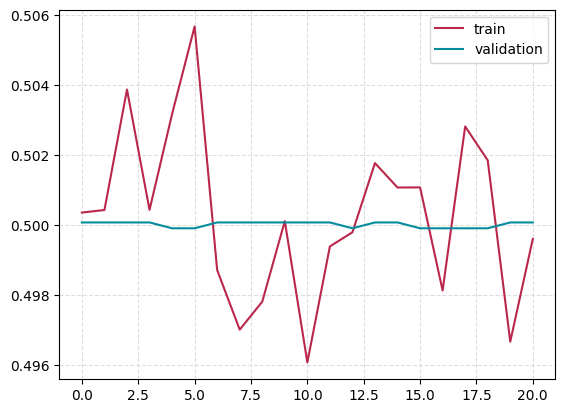

In [ ]:
plt.plot(train_accs_u, label="train",color='#BA274A')
plt.plot(val_accs_u, label="validation",color='#068D9D')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.87')

b. Describe the setting choices you have made to underfit the data and explain why these settings contributed to a low train and validation accuracy. [1 point]


**Fewer Filters with Wider Receptive Field (filter_widths=[25]):**

Using fewer filters with a wider receptive field can reduce the network's ability to detect finer details and local features in the input data. Although wider filters can capture more global information, they overlook subtle patterns.

**Fewer Channels (nchannels=[4, 8]):**

Reducing the number of channels in each convolutional layer limits the network's capacity to learn and represent a diverse set of features from the input data, leading to a simpler representation that may not capture all the necessary information.

**Fewer Hidden Units (n_hidden=12):**

Decreasing these can lead to a reduction in the network's capacity to synthesize the information learned in the convolutional layers.

**Increased Dropout (dropout=0.9):**

With a very high dropout rate, means that a large proportion of neuron outputs are excluded during training. Which can prevent it from fitting the training data well, and hinder its ability to learn.

**Higher Learning Rate (lr=0.1):**

A higher learning rate can cause the model's weights to update too aggressively during training. This can lead to the model overshooting the optimal values during optimization, preventing it from converging to a good solution.


Underfitting is characterized by poor performance on both training and validation datasets, as the model lacks the capacity or hasn't learned adequately to make accurate predictions.

*Fill in with your explanation. Feel free to add any plots or tables if you feel they will be helpful.*

## Question 2 [4 points]

a. Find settings of `CNN_1d` that that overfit (high train accuracy but low validation accuracy). [3 points]

In [ ]:
cnn_1d_overfit = CNN_1d(n_output_channels=1,
                          filter_widths=[15,5],
                          num_chunks=10,
                          max_pool_factor=2,
                          nchannels=[4,64,32],
                          n_hidden=64, # more hidden units
                          dropout=0.0) # no dropout
my_cnn1d_overfit, train_accs_o, val_accs_o = train_model(cnn_1d_overfit, train_data, validation_data,lr=1e-3)


Receptive field: 22 Chunk size: 4 Number chunks: 10
cuda
Epoch 1 took 3.98s. Train loss: 0.6542 acc: 0.6088. Val loss: 0.6318 acc: 0.6346. Patience left: 10
Epoch 2 took 2.41s. Train loss: 0.6120 acc: 0.6621. Val loss: 0.6241 acc: 0.6466. Patience left: 10
Epoch 3 took 1.81s. Train loss: 0.5936 acc: 0.6813. Val loss: 0.6206 acc: 0.6531. Patience left: 10
Epoch 4 took 1.31s. Train loss: 0.5783 acc: 0.6949. Val loss: 0.6341 acc: 0.6485. Patience left: 9
Epoch 5 took 1.29s. Train loss: 0.5634 acc: 0.7078. Val loss: 0.6629 acc: 0.6308. Patience left: 8
Epoch 6 took 1.30s. Train loss: 0.5487 acc: 0.7200. Val loss: 0.6830 acc: 0.6229. Patience left: 7
Epoch 7 took 1.34s. Train loss: 0.5338 acc: 0.7325. Val loss: 0.6853 acc: 0.6255. Patience left: 6
Epoch 8 took 1.34s. Train loss: 0.5201 acc: 0.7422. Val loss: 0.6683 acc: 0.6383. Patience left: 5
Epoch 9 took 1.32s. Train loss: 0.5074 acc: 0.7516. Val loss: 0.6604 acc: 0.6466. Patience left: 4
Epoch 10 took 1.33s. Train loss: 0.4957 acc: 0.75

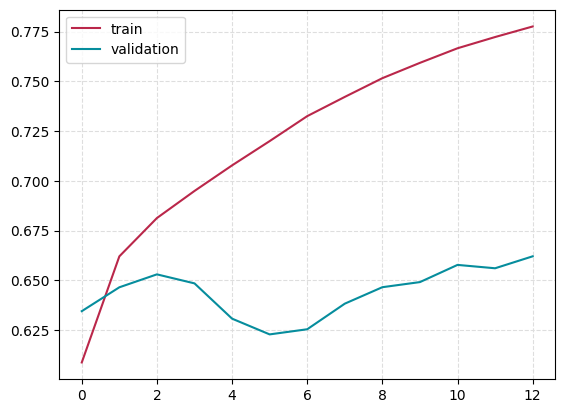

In [ ]:
plt.plot(train_accs_o, label="train",color='#BA274A')
plt.plot(val_accs_o, label="validation",color='#068D9D')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.87')

b. Describe the setting choices you have made to overfit the data and explain why these settings contributed to a high train and low validation accuracy. [1 point]

**Increased Number of Chunks (num_chunks=10):**

By doubling the number of chunks, we're increasing the granularity at which the network processes the data. This could allow the model to focus on and overfit to very specific patterns within the training data, potentially at the expense of its ability to generalize.

**Lower Pooling Factor (max_pool_factor=2):**

Reducing the max pooling factor leads to less aggressive spatial reduction retaining more informationfrom the input, allowing the network to learn very detailed features that might be specific to the training data.

**More Channels in Layers (nchannels=[4,64,32]):**

By increasing the number of channels we're significantly increasing the model's capacity. This allows the network to learn a larger set of features, which can be beneficial for capturing complex patterns but also risks overfitting to the training data.

**More Hidden Units (n_hidden=64):**

Increasing the number of hidden units enhances the model's ability to synthesize and interpret the features extracted by the convolutional layers. While this can improve learning capacity, it can also make the model more prone to memorizing specific training examples.

**No Dropout (dropout=0.0):**

Given that dropout is a regularization technique that helps prevent overfitting by setting dropout to 0, we remove this regularization and its capacity for generalization, allowing the network to rely on specific patterns found in the training data too heavily.


## Question 3  [6 points]

a. Carefully explore varying one architectural choice (e.g.  depth, number of channels, filter width, regularization, pooling factor, optimizer, learning rate, batch size, activation function, normalization, or skip connections). Report the final train and validation accuracy as a function of this choice.

For example you might vary the number of convolutional layers from 1 to 4, keeping everything else the same, and plot validation accuracy vs number of layers. [4 points]

In [ ]:
n_output_channels = 1
num_chunks = 5
max_pool_factor = 4
n_hidden = 32
dropout = 0.2
base_filter_width = 15

results = []
for num_layers in range(1, 5):
    filter_widths = [15] + [5] * (num_layers - 1)

    print(filter_widths)

    nchannels = [4,32] + [32] * (num_layers - 1)

    print(nchannels)
    # Construct the CNN with the given parameters
    cnn = CNN_1d(n_output_channels=n_output_channels,
                  filter_widths=filter_widths,
                  num_chunks=num_chunks,
                  max_pool_factor=max_pool_factor,
                  nchannels=nchannels,
                  n_hidden=n_hidden,
                  dropout=dropout)

    # Training
    cnn_d, train_accs, val_accs= train_model(cnn, train_data, validation_data,lr=1e-3)

    results.append({'num_layers': num_layers, 'train_acc': train_accs, 'val_acc': val_accs})



[15]
[4, 32]
Receptive field: 14 Chunk size: 4 Number chunks: 5
cuda
Epoch 1 took 0.93s. Train loss: 0.6814 acc: 0.5571. Val loss: 0.6676 acc: 0.5801. Patience left: 10
Epoch 2 took 0.91s. Train loss: 0.6682 acc: 0.5847. Val loss: 0.6615 acc: 0.5919. Patience left: 10
Epoch 3 took 1.53s. Train loss: 0.6647 acc: 0.5922. Val loss: 0.6581 acc: 0.5973. Patience left: 10
Epoch 4 took 1.58s. Train loss: 0.6603 acc: 0.5983. Val loss: 0.6546 acc: 0.6008. Patience left: 10
Epoch 5 took 1.58s. Train loss: 0.6566 acc: 0.6028. Val loss: 0.6506 acc: 0.6067. Patience left: 10
Epoch 6 took 1.12s. Train loss: 0.6541 acc: 0.6042. Val loss: 0.6481 acc: 0.6151. Patience left: 10
Epoch 7 took 1.45s. Train loss: 0.6493 acc: 0.6139. Val loss: 0.6444 acc: 0.6219. Patience left: 10
Epoch 8 took 1.65s. Train loss: 0.6477 acc: 0.6151. Val loss: 0.6437 acc: 0.6236. Patience left: 10
Epoch 9 took 1.74s. Train loss: 0.6457 acc: 0.6181. Val loss: 0.6425 acc: 0.6258. Patience left: 10
Epoch 10 took 0.93s. Train loss

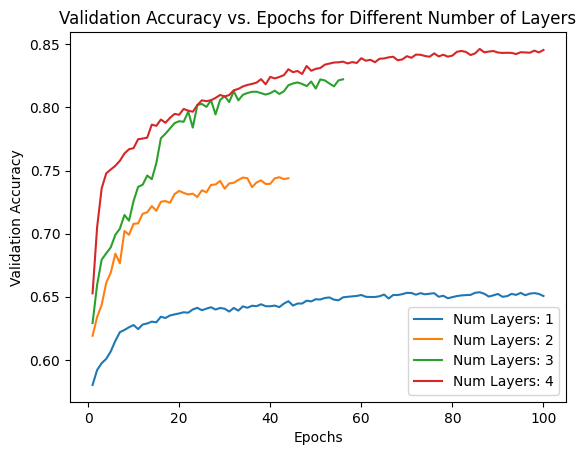

In [ ]:
for result in results:
    num_layers = result['num_layers']
    val_acc = result['val_acc']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, label=f'Num Layers: {num_layers}')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs for Different Number of Layers')
plt.legend()

plt.show()

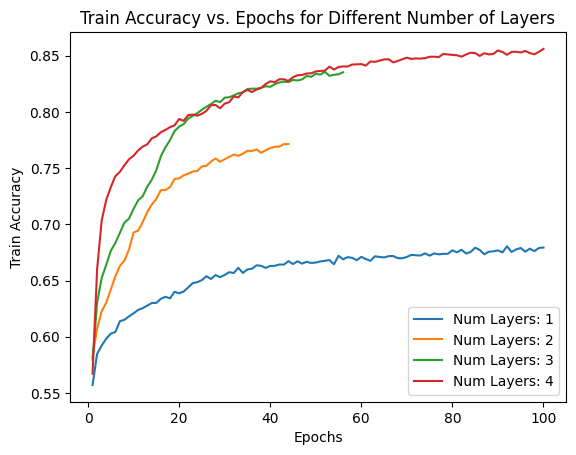

In [ ]:
for result in results:
    num_layers = result['num_layers']
    train_acc = result['train_acc']
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, label=f'Num Layers: {num_layers}')

plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs. Epochs for Different Number of Layers')
plt.legend()

plt.show()

We decided to explore the impact of varying the depth of our convolutional neural network (CNN) while keeping the number of nodes in each layer constant. This approach allowed us to isolate the effect of depth on the network's performance.

Our analysis ranged from 1 to 4 layers, with each additional layer designed to increase the network's ability to learn more complex features. A key aspect of the architecture of our CNN was maintaining a consistent number of nodes across all layers, ensuring that any observed performance differences were attributable primarily to changes in depth rather than variations in the network's capacity.


With only one layer, our network's performance plateaued at a relatively lower level, both in terms of training and validation accuracy. This outcome can be attributed to the limited capacity of a single-layer network, which restricts its ability to capture and represent the complex hierarchies of features often present in the data. The simplicity of the network, while computationally efficient, limits its ability to generalize well.

Adding just one more layer resulted in a substantial improvement in performance. This increase in performance highlights the importance of depth in CNNs. With two layers, the network can extract more features from the input data, effectively building a more  informative representation. This enables better fitting to the training data and improved generalization to unseen data.

As we extended the depth to three and four layers, we observed that while there were improvements, they were not as pronounced as the jump from one to two layers. The network with three and four layers showed similar levels of performance. This suggests that beyond a certain depth, the additional complexity of extra layers does not contribute greatly to learning more relevant features for this particular task and dataset.

In addition, the filters added proportionally to the number of layers allows the network to capture both broad and fine-grained features from the input data.

In conclusion, our analysis emphasizes the role of depth in enhancing a CNN's feature extraction capabilities. However, it also reveals that simply increasing depth, especially without adjusting other architectural parameters such as the number of nodes, may not always lead to proportional gains in performance.

b. For your selected architectural choice, discuss how and why varying this option affected your training and validation accuracy. [2 points]

*Fill in with your explanation. Feel free to add any plots or tables if you feel they will be helpful.*



## Question 4 [8 points]

a. Get as good validation accuracy as you can! [4 points]

Optionally you can try some more advanced extensions, e.g.
1. Adding some [Recurrent Layers](https://pytorch.org/docs/stable/nn.html#recurrent-layers). Be warned that `torch` assumes the opposite dimensions for convolutional vs recurrent layers so you'll want to use `torch.transpose` appropriately.
2. Transcription factors can bind to either strand of the DNA so you might want to include the [reverse complement](https://www.bx.psu.edu/old/courses/bx-fall08/definitions.html) (RC) in addition to the normal input. The simplest way to do this would be to train on both the original sequence and the RC (a form of data augmentation). Slightly fancier: run a copy of the network on the RC and take the max of the output from the two networks. Fancier approach here: https://www.biorxiv.org/content/10.1101/103663v1
3. Changing `BedPeaksDataset` to generate more negative examples in the space between peaks (although you'd only want to do this on the training data so you keep a fixed validation set). You will want to "cancel out" the additional negative examples by downweighting them in the loss.

In [86]:
class CNN_1d_boost(nn.Module):

    def __init__(self,
                 n_output_channels = 1,
                 filter_widths = [15, 5],
                 num_chunks = 5,
                 max_pool_factor = 4,
                 nchannels = [4, 32, 32],
                 n_hidden = 32,
                 dropout = 0.2):

        super(CNN_1d_boost, self).__init__()
        self.rf = 0 # running estimate of the receptive field
        self.chunk_size = 1 # running estimate of num basepairs corresponding to one position after convolutions

        conv_layers = []
        for i in range(len(nchannels)-1):
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding = 5),
                        nn.BatchNorm1d(nchannels[i+1]), # tends to help give faster convergence: https://arxiv.org/abs/1502.03167
                        nn.Dropout2d(dropout), # popular form of regularization: https://jmlr.org/papers/v15/srivastava14a.html
                        nn.MaxPool1d(max_pool_factor),
                        nn.ELU(inplace=True)  ] # popular alternative to ReLU: https://arxiv.org/abs/1511.07289
            assert(filter_widths[i] % 2 == 1) # assume this
            self.rf += (filter_widths[i] - 1) * self.chunk_size
            self.chunk_size *= max_pool_factor

        # If you have a model with lots of layers, you can create a list first and
        # then use the * operator to expand the list into positional arguments, like this:
        self.conv_net = nn.Sequential(*conv_layers)

        self.seq_len = num_chunks * self.chunk_size + self.rf # amount of sequence context required


        print("Receptive field:", self.rf, "Chunk size:", self.chunk_size, "Number chunks:", num_chunks)
        # Recurrent Layers
        # type of deep neural network where both input data and prior hidden states are fed into the network's layers, giving the network a state and hence memory.
        ###Adding some Recurrent Layers.
        #Be warned that torch assumes the opposite dimensions for convolutional vs recurrent layers so you'll want to use torch.transpose appropriately.

        n_recurrent_layers = 1 #same for this, tried with 4 and overfitted
        hidden_size=32# we added more because we can capture more information at each step, pottentially allowing to find complex patterns

        #Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence
        #CLASStorch.nn.LSTM(self, input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)
        # The input dimension to the LSTM is the last channel number of the conv layers

        self.lstm = nn.LSTM(input_size=nchannels[-1], hidden_size=hidden_size,
                                    num_layers=n_recurrent_layers, batch_first=True,dropout=0,bidirectional=False)

        #self.rnn = nn.RNN(input_size=nchannels[-1], hidden_size=hidden_size,
        #          num_layers=n_recurrent_layers, batch_first=True)

        #self.dense_net = nn.Sequential( nn.Linear(nchannels[-1] * num_chunks, n_hidden),
         #                               nn.Dropout(dropout),
          #                              nn.ELU(inplace=True),
           #                             nn.Linear(n_hidden, n_output_channels) )

        self.dense_net = nn.Sequential(
            nn.Linear(hidden_size, n_hidden), #matching hidden size
            nn.Dropout(dropout),
            nn.ELU(inplace=True),
            nn.Linear(n_hidden, n_output_channels)
        )


    def forward(self, x):
        net = self.conv_net(x)# [batch, n_channels[-1], seq_len]
        net = net.transpose(1, 2)  # Now shape is [batch, seq_len,n_channels[-1]]
        net, (hn, cn) = self.lstm(net) #LSTM forward pass
        net = hn[-1] #flatten to send to dens layer
        net = self.dense_net(net) # dense layer forward pass i want to modify my LSTM forRNN



        return net


In [87]:
atac_data = pd.read_csv(DATADIR + "ATAC_data.bed.gz", sep='\t', names=("chrom","start","end"))
atac_data = atac_data.sort_values(['chrom', 'start']) # actually already sorted but why not

validation_chromosomes = ["chr3","chr4"]
validation_data = atac_data[ atac_data['chrom'].isin(validation_chromosomes) ]

train_data = atac_data[ ~atac_data['chrom'].isin( validation_chromosomes ) ]

train_data.shape[0] / atac_data.shape[0], validation_data.shape[0] / atac_data.shape[0]

(0.812797461660497, 0.1872025383395029)

In [88]:
n_output_channels = 1
num_chunks = 5
max_pool_factor = 4
n_hidden = 32
dropout = 0.2
filter_widths = [15, 5, 5, 5]
nchannels = [4, 32, 32, 32, 32]

#RNN is set up to have 1 layers with 32 features
cnn_1d_b = CNN_1d_boost(n_output_channels=n_output_channels,
                  filter_widths=filter_widths,
                  num_chunks=num_chunks,
                  max_pool_factor=max_pool_factor,
                  nchannels=nchannels,
                  n_hidden=n_hidden,
                  dropout=dropout)

Receptive field: 350 Chunk size: 256 Number chunks: 5


In [90]:
scheduler = StepLR(optimizer, step_size=30, gamma=0.1) # didn't work :(

cnn_b, train_b, val_b = train_model(cnn_1d_b, train_data, validation_data,
                                    model_name="checkpoint_boost_jcc2340.pt",
                                    lr=3e-3)



Training on device: cuda
Epoch 1 took 23.27s. Train loss: 0.6556 acc: 0.5967. Val loss: 0.6532 acc: 0.5983. Patience left: 10
Epoch 2 took 23.07s. Train loss: 0.6473 acc: 0.6102. Val loss: 0.6416 acc: 0.6189. Patience left: 10
Epoch 3 took 27.21s. Train loss: 0.6260 acc: 0.6430. Val loss: 0.5948 acc: 0.6745. Patience left: 10
Epoch 4 took 23.80s. Train loss: 0.5774 acc: 0.6989. Val loss: 0.5161 acc: 0.7476. Patience left: 10
Epoch 5 took 22.92s. Train loss: 0.5330 acc: 0.7371. Val loss: 0.5013 acc: 0.7616. Patience left: 10
Epoch 6 took 26.92s. Train loss: 0.5019 acc: 0.7562. Val loss: 0.4859 acc: 0.7718. Patience left: 10
Epoch 7 took 23.03s. Train loss: 0.4871 acc: 0.7682. Val loss: 0.4787 acc: 0.7759. Patience left: 10
Epoch 8 took 22.91s. Train loss: 0.4729 acc: 0.7767. Val loss: 0.4586 acc: 0.7833. Patience left: 10
Epoch 9 took 27.05s. Train loss: 0.4634 acc: 0.7803. Val loss: 0.4470 acc: 0.7941. Patience left: 10
Epoch 10 took 26.42s. Train loss: 0.4506 acc: 0.7916. Val loss: 0.

In [93]:
cnn_b

CNN_1d_boost(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,), padding=(5,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): ELU(alpha=1.0, inplace=True)
    (10): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout2d(p=0.2, inplace=False)
    (13): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (14): ELU(alpha=1.0, inplac

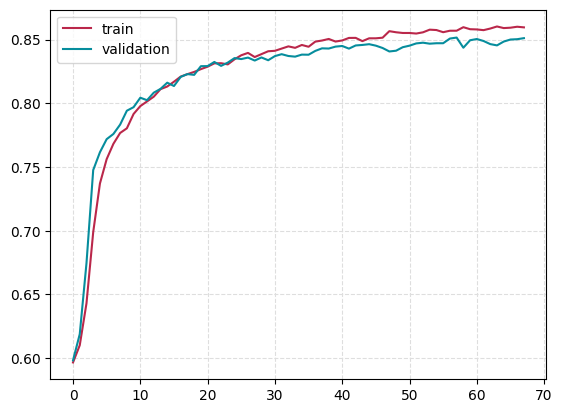

In [91]:
import matplotlib.pyplot as plt
plt.plot(train_b, label="train",color='#BA274A')
plt.plot(val_b, label="validation",color='#068D9D')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.87')

b. What gave you the biggest boost in performance? Why do you think that is? [2 points]

After thorough experimentation, we've converged on an optimal architecture for our model that delivers the best performance so far (as explained previously) [refer to question 3 explanation]. The architecture is as follows:

```
n_output_channels = 1
num_chunks = 5
max_pool_factor = 4
n_hidden = 32
dropout = 0.2
filter_widths = [15, 5, 5, 5]
nchannels = [4, 32, 32, 32, 32]
```

In addition to these configurations, we've integrated an Long Short-Term Memory (LSTM) layer (with 32 nodes) into our model. This decision was motivated by the LSTM's ability to capture sequential information, and its capability of learning long-term dependencies in sequential data which are often crucial for accurate predictions.

```
n_recurrent_layers = 1
hidden_size=32
self.lstm = nn.LSTM(input_size=nchannels[-1], hidden_size=hidden_size,
                      num_layers=n_recurrent_layers, batch_first=True,dropout=0,bidirectional=False)

```

Despite our expectations, the enhancement of our model through the integration of an LSTM layer resulted in a modest improvement rather than a substantial boost. Nonetheless, this modification successfully increased the accuracy of our predictions while simultaneously reducing the loss.

*Fill in with your explanation. Feel free to add any plots or tables if you feel they will be helpful.*

c.  Use some model interpretability technique to visualize why the model has made the assignments it did for a few examples. This can be one of the methods shown above (in silico mutagenesis or saliency maps) or one of the methods linked under *Other interpretation approaches*. [2 points]

In [95]:
cnn_1d_b.to(device)

print(device)

validation_dataset = BedPeaksDataset(validation_data, genome, cnn_1d_b.seq_len)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)


cuda


In [96]:
cnn_1d_b

CNN_1d_boost(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(15,), stride=(1,), padding=(5,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): ELU(alpha=1.0, inplace=True)
    (10): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout2d(p=0.2, inplace=False)
    (13): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (14): ELU(alpha=1.0, inplac

In [97]:
torch.set_grad_enabled(False)

for (x_cpu,y_cpu) in validation_dataloader:
    x = x_cpu.to(device)
    y = y_cpu.to(device)
    output = cnn_1d_b(x).squeeze()
    output = torch.sigmoid(output)
    delta_output = torch.zeros_like(x, device=device)
    # loop over all positions changing to each position nucleotide
    # note everything is implicitly parallelized over the batch here
    for seq_idx in range(cnn_1d_b.seq_len): # iterate over sequence
        for nt_idx in range(4): # iterate over nucleotides
            x_prime = x.clone() # make a copy of x
            x_prime[:,:,seq_idx] = 0. # change the nucleotide to nt_idx
            x_prime[:,nt_idx,seq_idx] = 1.
            output_prime = cnn_1d_b(x_prime).squeeze()
            output_prime = torch.sigmoid(output_prime)
            delta_output[:,nt_idx,seq_idx] = output_prime - output
    break # just do this for first batch

print(x.shape)

torch.Size([1000, 4, 1630])


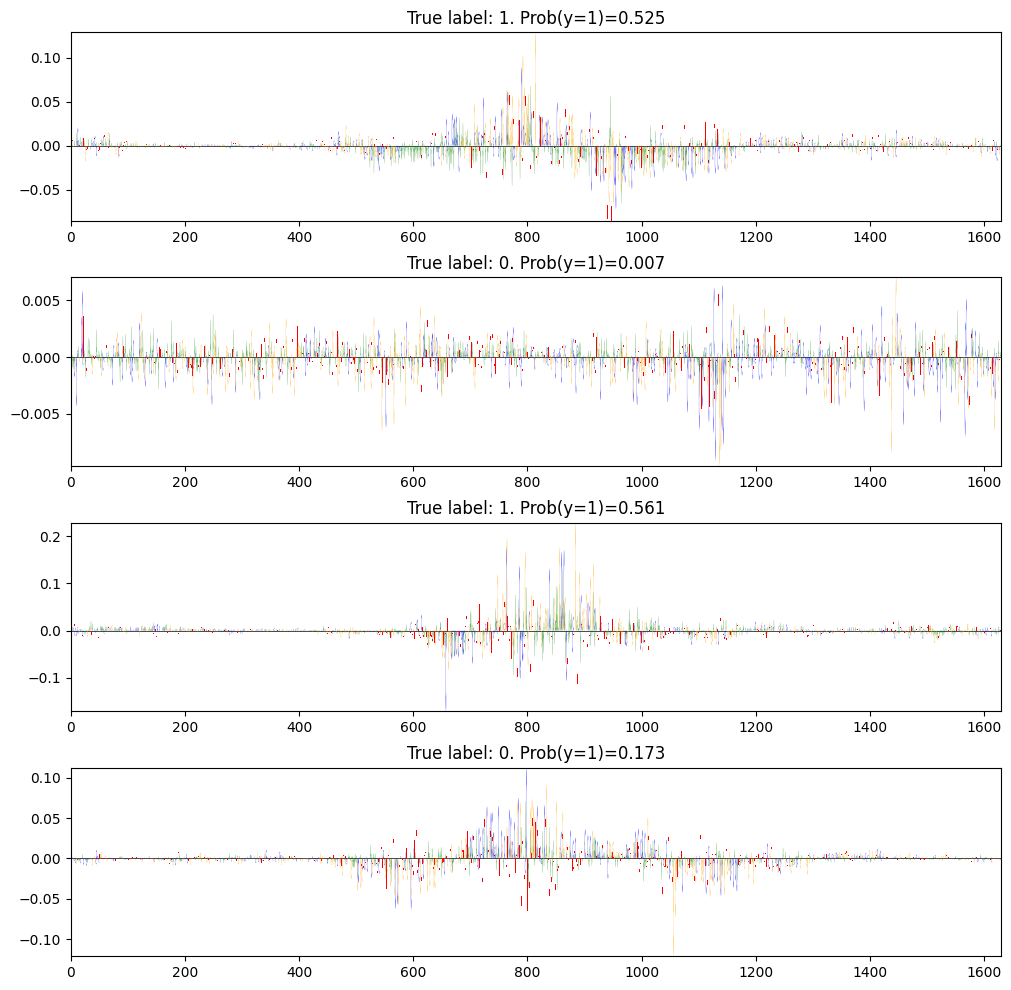

In [98]:
torch.set_grad_enabled(True)
optimizer = torch.optim.Adam(cnn_1d_b.parameters(), amsgrad=True,lr=3e-3)

cnn_1d_b.train() # model in training mode

x.requires_grad_() # tell torch we will want gradients wrt x (which we don't normally need)

output = cnn_1d_b(x).squeeze()
output = torch.sigmoid(output)
dummy = torch.ones_like(output) # in a multiclass model this would be a one-hot encoding of y
output.backward(dummy) # to get derivative wrt to x
gradient_np = x.grad.detach().cpu().numpy()
output_np = output.detach().cpu().numpy()
saliency = gradient_np * x_cpu.numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i) #,sharey=ax)
    pwm_df = pd.DataFrame(data = saliency[i,:,:].transpose(), columns=("A","C","G","T"))
    logomaker.Logo(pwm_df, ax=ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

## Question 5  [6 points]

The final task is to submit your best performing model's predictions on chromosomes 1 and 2 to [our ModelShare competition](https://www.modelshare.org/detail/model:1484).

You can change what train/validation split you use here also if you want: e.g. you could do K-fold cross-validation or even retrain including the validation data if you think it will help (although early stopping may not work any more).

First we'll need to load the test regions:

In [99]:
test_data = pd.read_csv(DATADIR + "ATAC_test_regions.bed.gz", sep='\t', names=("chrom","start","end"))
test_data.head(10)

,chrom,start,end
0,chr1,713980,714180
1,chr1,2159194,2159394
2,chr1,1185163,1185363
3,chr1,2721699,2721899
4,chr1,2232837,2233037
5,chr1,2462557,2462757
6,chr1,2601580,2601780
7,chr1,2638010,2638210
8,chr1,3393795,3393995
9,chr1,3418525,3418725


Unlike the training data we've included random (in number and in genomic position) negative (no binding) regions in this bed file since otherwise you'd know implicitly that all the loaded regions are positives!

We'll use a new `Dataset` class and `DataLoader` to match predictions on the test data in batches:

In [100]:
class BedPeaksDatasetTest(torch.utils.data.IterableDataset):

    def __init__(self, atac_data, genome, context_length):
        super(BedPeaksDatasetTest, self).__init__()
        self.context_length = context_length
        self.atac_data = atac_data
        self.genome = genome

    def __iter__(self):
        for row in self.atac_data.itertuples():
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chrom][ midpoint - self.context_length//2:midpoint + self.context_length//2]
            yield(one_hot(seq))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = BedPeaksDatasetTest(test_data, genome, cnn_1d_b.seq_len)
# you can always use a smaller batchsize if you ended up using a really big model
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, num_workers = 0)

outputs = []
for x in test_dataloader: # iterate over batches
    x = x.to(device)
    cnn_1d_b.train()
    output = cnn_1d_b(x).squeeze() # your awesome model here!
    output = torch.sigmoid(output)
    output_np = output.detach().cpu().numpy()
    outputs.append(output_np)
output_np = np.concatenate(outputs)

predicted_values=output_np.tolist() # Create list of your predictions from test data
predicted_values[0:10] # check these aren't NaN or Inf which would suggest some numerical problem

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


[0.8579038381576538,
 0.7424309849739075,
 0.037027157843112946,
 0.09623350203037262,
 0.05587681382894516,
 0.6107111573219299,
 0.1218893975019455,
 0.08799788355827332,
 0.913985550403595,
 0.537458062171936]

In [102]:
predicted_values=output_np.tolist() # Create list of your predictions from test data
predicted_values = [int(val > 0.5) for val in predicted_values]
print(predicted_values)


[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 

Now you can make a submission to our class competition leaderboard!

1. Sign up for a username and password at www.modelshare.org/login.
2. Make sure your username is your Columbia Uni, so we know which submissions are yours.
3. Use the below code to submit your predictions to the class [leaderboard](https://www.modelshare.org/detail/model:1484) ***(click compete tab)***

For the assignment you only need to make one leaderboard submission, but you can upload two submissions per day until the deadline if you want!

Submission is worth 2 points, beating our baseline (auPR=0.822313) gets you 2 points and the other 2 points are for your tertile in the class (e.g. you get 2 points if you're in the top third, 1 point if you're in the middle third).

Install aimodelshare library

In [80]:
#! pip install aimodelshare --upgrade
!pip install --upgrade urllib3
! pip install  --upgrade aimodelshare
#! pip uninstall aimodelshare


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.8/975.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 

Set credentials using modelshare.org username/password

In [81]:
from aimodelshare.aws import set_credentials
#apiurl="https://yro0pg9wja.execute-api.us-east-2.amazonaws.com/prod/m" # 2022
apiurl = "https://zkq3lb2jx2.execute-api.us-east-2.amazonaws.com/prod/m" # 2023
set_credentials(apiurl=apiurl)

Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.


Load the competition.

In [82]:
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

Submit Model predictions to leaderboard (without extracting model architecture information):

Submit predictions to Competition Leaderboard (repeat with new predictions to submit again!)

In [103]:
mycompetition.submit_model(model=None,
                           preprocessor=None,
                           prediction_submission=predicted_values)

Insert search tags to help users find your model (optional): jcc2340
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 85

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:3866


Get leaderboard to check your performance

In [104]:
data = mycompetition.get_leaderboard() # this is a pandas dataframe
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,85.49%,84.62%,83.88%,86.25%,unknown,unknown,sf3096,70
1,85.08%,84.18%,83.45%,85.73%,unknown,unknown,sf3096,42
2,84.45%,83.63%,82.95%,85.59%,unknown,unknown,xh2628,20
3,84.45%,83.27%,82.67%,84.19%,unknown,unknown,sf3096,35
4,83.73%,82.74%,82.05%,84.24%,unknown,unknown,sf3096,34
5,83.69%,82.59%,81.92%,83.81%,unknown,unknown,as6734,19
6,83.59%,82.51%,81.84%,83.80%,unknown,unknown,hc3479,2
7,83.26%,82.37%,81.72%,84.23%,unknown,unknown,sf3096,33
8,83.11%,82.05%,81.38%,83.45%,unknown,unknown,jyy2140,73
9,82.17%,81.28%,80.71%,83.27%,unknown,unknown,sf3096,32


### Implementation of RC and GC
As a side note I implemented the reverse complement in my BedPeaksDataSet class, and it yielded amazing results! However when submitting the model with the new BedPeaksDatasetTest class, since it doesn't have my implementations, it only took into consideration my CNN architecture leading to awful performance! But feel free to run this code in order to observe the class enhancement.

In [ ]:

import random
from torch.utils.data import IterableDataset

# New class to incorporate reverse_complement and shuffling negative examples 
class BedPeaksDataset(IterableDataset):
    def __init__(self, atac_data, genome, context_length):
        super(BedPeaksDataset, self).__init__()
        self.context_length = context_length
        self.atac_data = atac_data
        self.genome = genome

    def reverse_complement(self, seq):
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C','N':'N'}
        return ''.join([complement[base] for base in reversed(seq)])

    def shuffle_sequence(self, seq):
        seq_list = list(seq)
        random.shuffle(seq_list)
        return ''.join(seq_list)

    def __iter__(self):
        prev_end = 0
        prev_chrom = ""
        for i, row in enumerate(self.atac_data.itertuples()):
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chrom][midpoint - self.context_length//2:midpoint + self.context_length//2]
            yield (one_hot(seq), np.float32(1))  # positive example
            yield (one_hot(self.reverse_complement(seq)), np.float32(1))  # reverse complement

            if prev_chrom == row.chrom and prev_end < row.start:
                midpoint = int(.5 * (prev_end + row.start))
                neg_seq = self.genome[row.chrom][midpoint - self.context_length//2:midpoint + self.context_length//2]
                neg_seq_shuffled = self.shuffle_sequence(neg_seq)
                yield (one_hot(neg_seq_shuffled), np.float32(0))  # shuffled negative example

            prev_chrom = row.chrom
            prev_end = row.end


In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_model(cnn_1d, train_data, validation_data, lr, epochs=100, patience=10, verbose=True, model_name="cnn_1d_checkpoint_new.pt", scheduler=None):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d.to(device)
    if verbose:
        print("Training on device:", device)

    # Initialize the datasets and dataloaders
    train_dataset = BedPeaksDataset(train_data, genome, cnn_1d.seq_len)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers=0)
    validation_dataset = BedPeaksDataset(validation_data, genome, cnn_1d.seq_len)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)

    # Initialize the optimizer
    optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True, lr=lr)

    # Training loop with early stopping
    train_accs, val_accs = [], []
    best_val_loss = np.inf
    patience_counter = patience

    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            torch.save(cnn_1d.state_dict(), model_name)
            best_val_loss = val_loss
            patience_counter = patience
        else:
            patience_counter -= 1
            if patience_counter <= 0:
                cnn_1d.load_state_dict(torch.load(model_name))
                break

        if scheduler:
            scheduler.step()

        elapsed = timeit.default_timer() - start_time
        if verbose:
            print(f"Epoch {epoch+1} took {elapsed:.2f}s. Train loss: {train_loss:.4f} acc: {train_acc:.4f}. Val loss: {val_loss:.4f} acc: {val_acc:.4f}. Patience left: {patience_counter}")

    return cnn_1d, train_accs, val_accs


In [ ]:
class CNN_1d_boost(nn.Module):

    def __init__(self,
                 n_output_channels = 1,
                 filter_widths = [15, 5],
                 num_chunks = 5,
                 max_pool_factor = 4,
                 nchannels = [4, 32, 32],
                 n_hidden = 32,
                 dropout = 0.2):

        super(CNN_1d_boost, self).__init__()
        self.rf = 0 # running estimate of the receptive field
        self.chunk_size = 1 # running estimate of num basepairs corresponding to one position after convolutions

        conv_layers = []
        for i in range(len(nchannels)-1):
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding = 10),
                        nn.BatchNorm1d(nchannels[i+1]), # tends to help give faster convergence: https://arxiv.org/abs/1502.03167
                        nn.Dropout2d(dropout), # popular form of regularization: https://jmlr.org/papers/v15/srivastava14a.html
                        nn.MaxPool1d(max_pool_factor),
                        nn.ELU(inplace=True)  ] # popular alternative to ReLU: https://arxiv.org/abs/1511.07289
            assert(filter_widths[i] % 2 == 1) # assume this
            self.rf += (filter_widths[i] - 1) * self.chunk_size
            self.chunk_size *= max_pool_factor

        # If you have a model with lots of layers, you can create a list first and
        # then use the * operator to expand the list into positional arguments, like this:
        self.conv_net = nn.Sequential(*conv_layers)

        self.seq_len = num_chunks * self.chunk_size + self.rf # amount of sequence context required


        print("Receptive field:", self.rf, "Chunk size:", self.chunk_size, "Number chunks:", num_chunks)
        # Recurrent Layers
        # type of deep neural network where both input data and prior hidden states are fed into the network's layers, giving the network a state and hence memory.
        ###Adding some Recurrent Layers.
        #Be warned that torch assumes the opposite dimensions for convolutional vs recurrent layers so you'll want to use torch.transpose appropriately.

        n_recurrent_layers = 2 #same for this, tried with 4 and overfitted
        hidden_size=8 # we added more because we can capture more information at each step, pottentially allowing to find complex patterns

        #Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence
        #CLASStorch.nn.LSTM(self, input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)
        # The input dimension to the LSTM is the last channel number of the conv layers

        self.lstm = nn.LSTM(input_size=nchannels[-1], hidden_size=hidden_size,
                                    num_layers=n_recurrent_layers, batch_first=True,dropout=0,bidirectional=False)

        #self.rnn = nn.RNN(input_size=nchannels[-1], hidden_size=hidden_size,
        #          num_layers=n_recurrent_layers, batch_first=True)

        #self.dense_net = nn.Sequential( nn.Linear(nchannels[-1] * num_chunks, n_hidden),
         #                               nn.Dropout(dropout),
          #                              nn.ELU(inplace=True),
           #                             nn.Linear(n_hidden, n_output_channels) )

        self.dense_net = nn.Sequential(
            nn.Linear(hidden_size, n_hidden), #matching hidden size
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_output_channels)
        )


    def forward(self, x):
        net = self.conv_net(x)# [batch, n_channels[-1], seq_len]
        net = net.transpose(1, 2)  # Now shape is [batch, seq_len,n_channels[-1]]
        net, (hn, cn) = self.lstm(net) #LSTM forward pass
        net = hn[-1] #flatten to send to dens layer
        net = self.dense_net(net) # dense layer forward pass i want to modify my LSTM for RNN -> didn't improve, we stayed with LSTM



        return net


In [ ]:
n_output_channels = 1
num_chunks = 5
max_pool_factor = 4
n_hidden = 8
dropout = 0.2
filter_widths = [15, 5]
nchannels = [4, 32, 32]

cnn_1d_b = CNN_1d_boost(n_output_channels=n_output_channels,
                  filter_widths=filter_widths,
                  num_chunks=num_chunks,
                  max_pool_factor=max_pool_factor,
                  nchannels=nchannels,
                  n_hidden=n_hidden,
                  dropout=dropout)


In [ ]:
atac_data = pd.read_csv(DATADIR + "ATAC_data.bed.gz", sep='\t', names=("chrom","start","end"))
atac_data = atac_data.sort_values(['chrom', 'start']) # actually already sorted but why not

validation_chromosomes = ["chr3","chr4"]
validation_data = atac_data[ atac_data['chrom'].isin(validation_chromosomes) ]

train_data = atac_data[ ~atac_data['chrom'].isin( validation_chromosomes ) ]

train_data.shape[0] / atac_data.shape[0], validation_data.shape[0] / atac_data.shape[0]

In [ ]:

cnn_b, train_b, val_b = train_model(cnn_1d_b, train_data, validation_data,
                                    model_name="checkpoint_boost_jcc2340_RC.pt",
                                    lr=5e-3)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_b, label="train",color='#BA274A')
plt.plot(val_b, label="validation",color='#068D9D')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.87')

After thorough experimentation, we've converged on an "optimal" architecture for our model that delivers the best performance so far (as explained previously) [refer to question 3 explanation]. The architecture is as follows:

```
n_output_channels = 1
num_chunks = 5
max_pool_factor = 4
n_hidden = 32
dropout = 0.2
filter_widths = [15, 5, 5, 5]
nchannels = [4, 32, 32, 32, 32]
```
However, we encountered significant computational demands with this architecture. As detailed previously, adding an extra layer did not significantly enhance performance, leading us to adopt a simpler architecture. To enhance the model's specificity, we included the reverse complement of our positive examples in the BedPeaksDataset class. This addition was crucial because our target transcription factor could potentially bind to both strands of the DNA, necessitating a more complex approach to training data selection.

```
n_output_channels = 1
num_chunks = 5
max_pool_factor = 4
n_hidden = 32
dropout = 0.2
filter_widths = [15, 5]
nchannels = [4, 32, 32]
```

```
 def reverse_complement(self, seq):
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C','N':'N'}
        return ''.join([complement[base] for base in reversed(seq)])

```

This approach allows our model to consider both the forward and reverse orientations of DNA sequences, reflecting the biological reality that transcription factors can bind to either strand. Training on both orientations provides a more comprehensive understanding of potential binding sites, leading to improved model accuracy and specificity. Essentially, it doubles the contextual data for each binding site, offering a more detailed perspective for the model to learn from.


In addition to those configurations and arrangements, we've integrated an Long Short-Term Memory (LSTM) layer (with 32 nodes) into our model. This decision was motivated by the LSTM's ability to capture sequential information, and its capability of learning long-term dependencies in sequential data which are often crucial for accurate predictions.

```
n_recurrent_layers = 1
hidden_size=32
self.lstm = nn.LSTM(input_size=nchannels[-1], hidden_size=hidden_size,
                      num_layers=n_recurrent_layers, batch_first=True,dropout=0,bidirectional=False)

```

Despite our expectations, the enhancement of our model through the integration of an LSTM layer resulted in a modest improvement rather than a substantial boost. Nonetheless, this modification successfully increased the accuracy of our predictions while simultaneously reducing the loss. 

Contrastingly, the addition of reverse complement sequences markedly boosted our model's predictive accuracy. This improvement can be attributed to the increased dataset diversity and the more comprehensive representation of potential binding sites. By training on both the original and reverse complement sequences, the model gains a more robust understanding of the binding motifs, accounting for their presence on either DNA strand.